In [ ]:
# Pytorh
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# For showing data types
from typing import List, Tuple

np.random.seed(1234)

In [4]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use CPU for this one
device = torch.device("cpu")
print(f"Using device: {device}")

NVIDIA GeForce GTX 1650
Using device: cpu


In [5]:
class DNN(nn.Module):
    """
    Simple feed-forward network with tanh activations between hidden layers
    and Xavier initialization
    """
    def __init__(self, layers: List[int]) -> None:
        super(DNN, self).__init__()

        if len(layers) < 2:
            raise ValueError("`layers` must contain at least input and output sizes.")

        modules = []
        # Build hidden layers with tanh activations
        for in_dim, out_dim in zip(layers[:-2], layers[1:-1]):
            modules.append(nn.Linear(in_dim, out_dim))
            modules.append(nn.Tanh())
        # Final output layer (no activation)
        modules.append(nn.Linear(layers[-2], layers[-1]))

        self.network = nn.Sequential(*modules)

        # Xavier initialize all layers
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

In [ ]:
class PINN():
    """
    Physics-Informed Neural Network for the Euler-Bernoulli beam equation.
    Approximates two outputs, w(x) and m(x), from input x.
    """

    VALID_BC = {"pinned", "fixed", "free"}

    def __init__(self, dnn: torch.nn.Module) -> None:
        """
        Args:
            dnn: The deep neural network used to approximate the solution.
        """

        self.track_loss = []

        # Learning rate
        self.lr_lbfgs = 0.01

        # Deep Neural Network
        self.dnn = dnn

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=self.lr_lbfgs,
            max_iter=2000,
            max_eval=2000,
            history_size=50,
            tolerance_grad=1e-10,
            tolerance_change= 1e-10
        )

        self.iter = 0

    def set_var(self, x: torch.Tensor, q: torch.Tensor, lb: str, rb: str) -> None:
        """ 
        Set input variables and boundary condition.
        Args:
            x: 1D tensor of training input locations.
            q: 1D tensor of load values at x.
            lb: left boundary condition type.
            rb: right boundary condition type.
        """
        # Validate BC strings
        for bc_name in (lb, rb):
            if bc_name not in self.VALID_BC:
                raise ValueError(
                    f"Invalid boundary condition '{bc_name}'."
                    f"Choose from {self.VALID_BC}."
                )

        self.x = x
        self.q = q
        self.lb = lb
        self.rb = rb

    def model_value(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Evaluate the model's predicted output variables at given points.
        Args:
            x: Input Tensor of shape (N, 1).
        Returns:
            Tuple[Tensor, Tensor]: w(x), m(x)
        """
        out = self.dnn(x)
        return out[:, 0:1], out[:, 1:2]
    
    def boundary_cond(
        self, 
        cond: str,
        w: torch.Tensor, 
        w_x: torch.Tensor, 
        m: torch.Tensor, 
        m_x: torch.Tensor
    ) -> torch.Tensor:
        """
        Compute boundary condition loss based on a named condition.
        Args: 
            w, m: Output values from model.
            w_x, m_x: Calculated derivatives using AD
        Returns:
            Tensor: Mean squared boundary loss.
        """

        bc_loss = 0

        match cond:
            case 'pinned':
                bc_loss += w**2 + m**2
            case 'fixed':
                bc_loss += w**2 + w_x**2
            case 'free':
                bc_loss += m**2 + m_x**2
        return bc_loss

    def loss_func(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute both the PDE and boundary condition loses for the given conditions.
        Args:
            x: Input Tensor for the network.
        Returns:
            Tuple[Tensor, Tensor]: PDE and boundary condition loss.
        """

        # Get network output
        w, m = self.model_value(x)

        # Compute derivatives of w(x)
        w_x = torch.autograd.grad(w, x, torch.ones_like(w), create_graph=True)[0]
        w_2x = torch.autograd.grad(w_x, x, torch.ones_like(w_x), create_graph=True)[0]

        # Compute derivatives of m(x)
        m_x = torch.autograd.grad(m, x, torch.ones_like(m), create_graph=True)[0]
        m_2x = torch.autograd.grad(m_x, x, torch.ones_like(m_x), create_graph=True)[0]

        # Boundary condition loss
        bc_loss = self.boundary_cond(self.lb, w[0], w_x[0], m[0], m_x[0])
        bc_loss += self.boundary_cond(self.rb, w[-1], w_x[-1], m[-1], m_x[-1])

        # PDE loss
        pde_loss = torch.mean(torch.pow(m_2x + self.q, 2))
        pde_loss += torch.mean(torch.pow(w_2x + m, 2))

        return pde_loss, bc_loss


    def lbfgs_func(self) -> torch.Tensor:
        """
        Wrapper for L-BFGS optimizer. Called internally by PyTorch's L-BFGS step.
        Returns:
            Tensor: Total loss.
        """
        pde_loss, bc_loss = self.loss_func(self.x)
        loss = pde_loss + bc_loss

        self.optimizer_lbfgs.zero_grad()
        loss.backward()
        self.track_loss.append(loss.item())

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
            print(f"PDE: {'{:e}'.format(pde_loss.item())}, BC: {'{:e}'.format(bc_loss.item())}")
        self.iter += 1
        return loss
    
    def train(self) -> None:
        """
        Train the model using L-BFGS optimizer
        """
        self.dnn.train()
        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, X: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Predict the networks outputs at given coordinates.
        Args:
            X: 1D array of beam coordinates.
        Returns:
            Tuple[Tensor, Tensor]: w(X), m(X)
        """
        
        x = torch.tensor(X, requires_grad=True, dtype=torch.float).to(device)

        self.dnn.eval()
        w_c, m_c = self.model_value(x)

        # Detach the Tensors from and eventual GPU and turn them into arrays
        w_c = w_c.detach().cpu().numpy()
        m_c = m_c.detach().cpu().numpy()
        return w_c, m_c

In [7]:
# Beam parameters
E = 70e9    # Young's modulus
I = 0.1**4 / 12     # Square cross section with lenght 0.1m
EI = E * I
L = 3.0     # Length of beam in m
Q = -20000.0    # Applied external load in N/m

In [8]:
# Exact analytical solutions
q1 = lambda x: Q / (24*EI) * (x**4 - 4*L*x**3 + 6*L**2*x**2) # Fixed, free, constant q
q2 = lambda x: Q / (48*EI) * (2*x**4 - 5*L*x**3 + 3*L**2*x**2) # Fixed, pinned, constant q
q3 = lambda x: Q / (24*EI) * (x**4 - 2*x**3*L + x*L**3) # Pinned, pinned, constant q

In [9]:
# Creating training inputs and model parameters
p = 1000
x = np.random.uniform(0, L, p)
x = np.append(x, [0, L]) # Add boundary points
x = np.sort(x).reshape(-1, 1)
x_hat = x / L

q = np.full_like(x, Q) 
q0 = np.max(np.abs(q))
q_hat = q / q0
lb = 'fixed'
rb = 'free'

x_t = torch.tensor(x_hat, device=device, requires_grad=True).float()
q_t = torch.tensor(q_hat, device=device).float()
layers = [1] + 3*[20] + [2]

<Figure size 600x300 with 0 Axes>

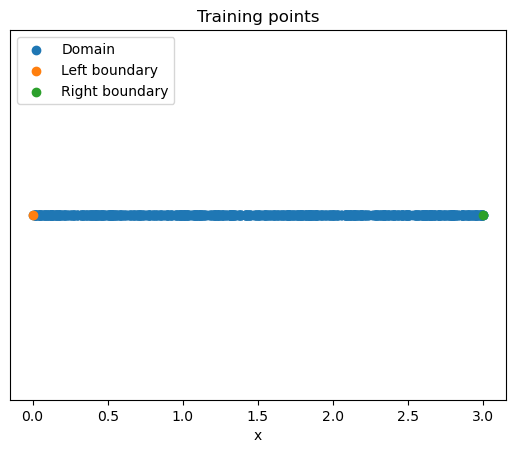

In [10]:
# Plotting training points
plt.figure(figsize=(6, 3))
fig, ax = plt.subplots()
ax.scatter(x[1:-1], np.zeros_like(x[1:-1]), label="Domain")
ax.scatter(x[0], np.zeros_like(x[0]), label="Left boundary")
ax.scatter(x[-1], np.zeros_like(x[-1]), label="Right boundary")
plt.title("Training points")
plt.xlabel("x")
ax.set_yticks([])

plt.legend(loc="upper left")

In [22]:
# Create a Deep Neural Network with the choosen size
model = DNN(layers).to(device)
print(model)

DNN(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=2, bias=True)
  )
)


In [23]:
pinn = PINN(model)
pinn.set_var(x_t, q_t, lb, rb)

In [24]:
%%time
pinn.train()

Iter: 0, Loss: 1.270555e+00
PDE: 6.469701e-01, BC: 6.235845e-01
Iter: 100, Loss: 1.091670e-01
PDE: 9.711102e-02, BC: 1.205598e-02
Iter: 200, Loss: 1.939171e-02
PDE: 1.924275e-02, BC: 1.489621e-04
Iter: 300, Loss: 9.885562e-04
PDE: 9.729965e-04, BC: 1.555971e-05
Iter: 400, Loss: 3.073524e-04
PDE: 3.059325e-04, BC: 1.419914e-06
Iter: 500, Loss: 1.849448e-04
PDE: 1.848149e-04, BC: 1.299739e-07
Iter: 600, Loss: 8.864878e-05
PDE: 8.859537e-05, BC: 5.340860e-08
Iter: 700, Loss: 5.050662e-05
PDE: 5.049292e-05, BC: 1.369683e-08
Iter: 800, Loss: 3.785891e-05
PDE: 3.785266e-05, BC: 6.255402e-09
Iter: 900, Loss: 2.785256e-05
PDE: 2.784664e-05, BC: 5.920552e-09
Iter: 1000, Loss: 2.063475e-05
PDE: 2.063171e-05, BC: 3.043855e-09
Iter: 1100, Loss: 1.480619e-05
PDE: 1.480427e-05, BC: 1.927087e-09
Iter: 1200, Loss: 1.082093e-05
PDE: 1.081696e-05, BC: 3.964091e-09
Iter: 1300, Loss: 7.750010e-06
PDE: 7.748146e-06, BC: 1.863439e-09
Iter: 1400, Loss: 5.590591e-06
PDE: 5.588890e-06, BC: 1.700220e-09
Iter: 1

In [ ]:
# Comparing prediction to exact solution
x = np.linspace(0, L, 200).reshape(-1, 1)

w, m = pinn.predict(x/L)
w_pred = (L**4 * q0 / EI) * w
m_pred = (L**2 * q0) * m

exact_solution = q1
w_exact = exact_solution(x)

w_error = np.linalg.norm(w_pred - w_exact) / np.linalg.norm(w_exact,2)
error = w_pred - w_exact
print(f"L2 Error: {w_error:.3e}")

L2 Error: 2.074e-04


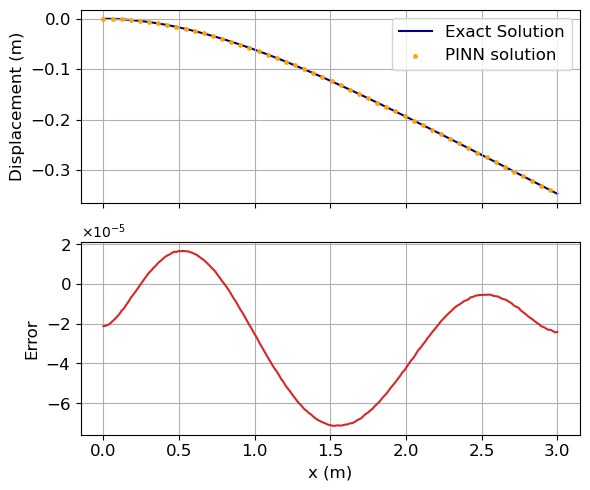

In [ ]:
# Plotting the prediction, exact solution and absolute error
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

ax1.plot(x, w_exact, label="Exact Solution", color="navy", zorder=1)
ax1.scatter(x[::4], w_pred[::4], label="PINN solution", s=6, color="orange", zorder=2)
ax1.set_ylabel('Displacement (m)', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid()

ax2.plot(x, error, 'tab:red')
ax2.set_xlabel('x (m)', fontsize=12)
ax2.set_ylabel('Error', fontsize=12)
ax2.grid()

# Tick label font size
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))  # Defines when to switch to scientific notation

ax2.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()